# Convolutional Neural Network

In [8]:
import sys
sys.path.insert(1, '../00_Classes')
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
import jupyprint.jupyprint as jp
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.signal import convolve2d

import CNN_Class

CNN = CNN_Class.MyCNN()
CNN.Rng(5) # imposto il seme per la generazione di numeri casuali sia per np.random che per random.

## Load data

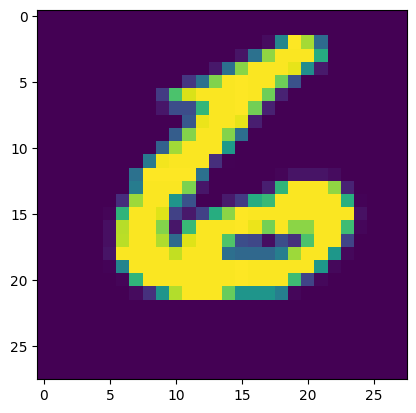

In [2]:
# Load data
images = CNN.load_MNIST_images('MNIST_data/t10k-images-idx3-ubyte.gz')
labels = CNN.load_MNIST_labels('MNIST_data/t10k-labels-idx1-ubyte.gz')

plt.imshow(images[9999])
plt.show()

## Definizione pesi

In [14]:
flag_load_weights = True

if flag_load_weights:
	with h5py.File('MnistConv.h5', 'r') as hf:
		W1 = hf['W1'][:]
		W5 = hf['W5'][:]
		Wo = hf['Wo'][:]

else:
	W1 = 1e-2 * np.random.randn(20, 9, 9)									
	W5 = (2 * np.random.rand(100, 2000) - 1) * np.sqrt(6) / np.sqrt(360 + 2000)
	Wo = (2 * np.random.rand(10, 100) - 1) * np.sqrt(6) / np.sqrt(10 + 100)

In [15]:
dict = {'W1': np.transpose(W1, (1,2,0)),
        'W5': W5,
        'Wo': Wo,
    	'X':np.transpose(images,(1,2,0)),
        'D':labels}
savemat('OurMnistConv.mat', dict)

## Training

In [4]:
N_tr_images = 7000
X = images[:N_tr_images ,: ,:]
D = labels[:N_tr_images]

In [6]:
# Training
for epoch in range(10):
	print(f"\rEpoch: {epoch + 1}", end='')
	sys.stdout.flush()
	W1, W5, Wo = CNN.SGD_MnistConv(W1, W5, Wo, X, D, 0.001, 0.95)

Epoch: 1

KeyboardInterrupt: 

## Salvataggio pesi

In [ ]:
flag_save = False

if flag_save:
	# Save model weights
	with h5py.File('MnistConv.h5', 'w') as hf:
		hf.create_dataset('W1', data=W1)
		hf.create_dataset('W5', data=W5)
		hf.create_dataset('Wo', data=Wo)

## Testing

In [ ]:
# Evaluation
# X_test = images[:7000, :, :]
# D_test = labels[:7000]
X_test = images[7001:10000, :, :]
D_test = labels[7001:10000]
acc = 0
N = len(D_test)

for k in range(N):
	print(f'\rSample: {int((k + 1)/len(D_test)*100)}%', end='')
	sys.stdout.flush()
	x = X_test[k, :, :]
	y1 = CNN.Conv(x, W1)
	y2 = CNN.ReLU(y1)
	y3 = CNN.Pool(y2)
	y4 = y3.flatten()
	v5 = W5 @ y4
	y5 = CNN.ReLU(v5)
	v = Wo @ y5
	y = CNN.Softmax(v)
	
	i = np.argmax(y)
	if i == D_test[k]:
		acc += 1
print()
acc = acc / N
print('Accuracy is %f' % acc)


Sample: 100%
Accuracy is 0.400133


## display_network

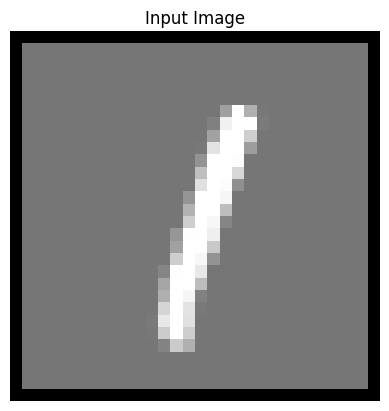

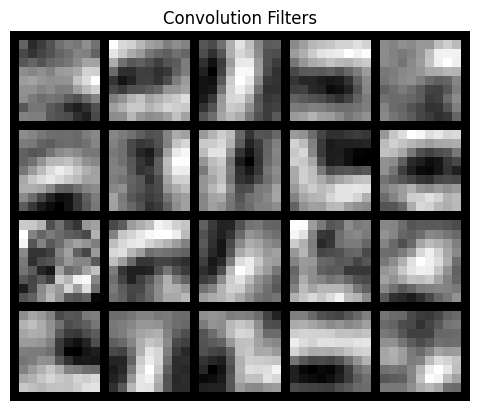

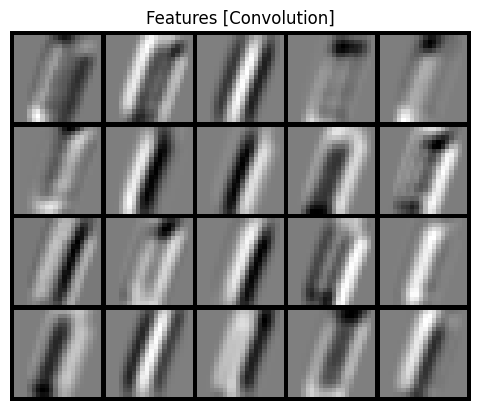

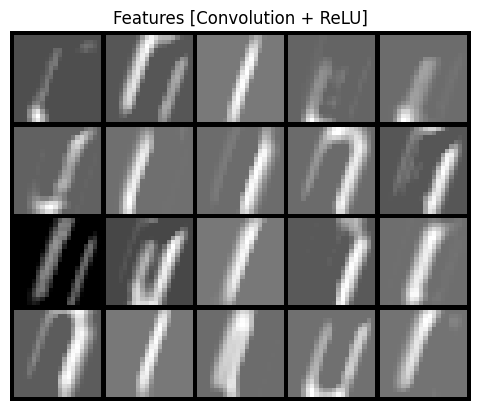

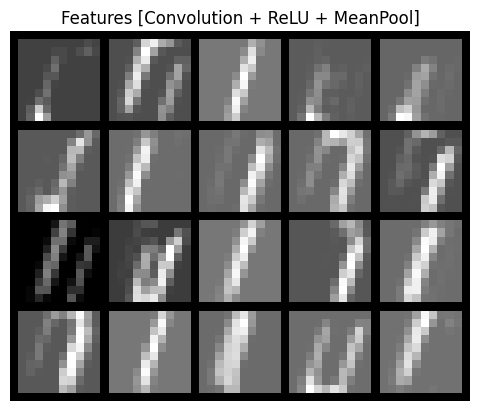

In [17]:
flag_load_mat = True	

if flag_load_mat:
	# Carica i dati dal file .mat
	data = loadmat('MnistConv.mat')
	X = data['X']
	W1 = data['W1']
	W5 = data['W5']
	Wo = data['Wo']
	X = np.transpose(X, (2, 0, 1))
	W1 = np.transpose(W1, (2, 0, 1))
else:
     X = images


# Esempio di utilizzo
k =  5


x =  X[k, :, :]
y1 = CNN.Conv(x, W1)
y2 = CNN.ReLU(y1)
y3 = CNN.Pool(y2)
y4 = y3.reshape(-1, 1)
v5 = W5 @ y4
y5 = CNN.ReLU(v5)
v =  Wo @ y5
y =  CNN.Softmax(v)

F = 20 
# Visualizza l'immagine di input
plt.figure()
CNN.display_network(x.reshape(-1, 1), title='Input Image')

# Visualizza i filtri di convoluzione
convFilters = np.zeros((9*9, F))
for i in range(F):
    filter = W1[i, :, :]
    convFilters[:, i] = filter.flatten()

plt.figure()
CNN.display_network(convFilters, title='Convolution Filters')

# Visualizza le caratteristiche [Convolution]
fList = np.zeros((20*20, F))
for i in range(F):
    feature = y1[i, :, :]
    fList[:, i] = feature.flatten()

plt.figure()
CNN.display_network(fList, title='Features [Convolution]')

# Visualizza le caratteristiche [Convolution + ReLU]
fList = np.zeros((20*20, F))
for i in range(F):
    feature = y2[i, :, :]
    fList[:, i] = feature.flatten()

plt.figure()
CNN.display_network(fList, title='Features [Convolution + ReLU]')

# Visualizza le caratteristiche [Convolution + ReLU + MeanPool]
fList = np.zeros((10*10, F))
for i in range(F):
    feature = y3[i, :, :]
    fList[:, i] = feature.flatten()

plt.figure()
CNN.display_network(fList, title='Features [Convolution + ReLU + MeanPool]')
